In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image
from skimage.util.shape import view_as_blocks
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import generate_data, extract_blocks, normalize_image
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

In [2]:
start_time = time.time()

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),  # Add dropout layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),  # Add dropout layer
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, x):
        print(f"{x.shape=}")
        x = self.encoder(x)
        print(f"{x.shape=}")
        x = self.decoder(x)
        print(f"{x.shape=}")
        return x


In [4]:
# Create an instance of the model
model = Autoencoder()

im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
# im = im.resize((512, 512))
image = np.array(im.convert('L'))
image_size = image.shape

data = generate_data(image, K=8000)
# Define transformation
transform = transforms.Compose([  # Resize to match image dimensions
    transforms.ToTensor()
])

data = transform(data).unsqueeze(0)  # Add batch dimension

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)

# # Training loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, data)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])


x.shape=torch.Size([1, 1, 8000, 64])
Epoch [1/200], Loss: 0.1855
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [2/200], Loss: 0.1425
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [3/200], Loss: 0.1153
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [4/200], Loss: 0.0923
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [5/200], Loss: 0.0766
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [6/200], Loss: 0.0654
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([1, 1, 8000, 64])
Epoch [7/200], Loss: 0.0573
x.shape=torch.Size([1, 1, 8000, 64])
x.shape=torch.Size([1, 32, 2000, 16])
x.shape=torch.Size([

In [5]:
# split the initial image in patches
validation_data = extract_blocks(image, block_size=(8,8))
validation_data = (transform(validation_data.reshape(-1, 64)).unsqueeze(0) * 255).float()

print(type(validation_data[0]))

# Denoise the image using the autoencoder
with torch.no_grad():
    denoised_patches = model(validation_data)



<class 'torch.Tensor'>
x.shape=torch.Size([1, 1, 148836, 64])
x.shape=torch.Size([1, 32, 37209, 16])
x.shape=torch.Size([1, 1, 148836, 64])


In [6]:
denoised_image = reconstruct_from_patches_2d(np.array(denoised_patches.reshape(-1, 8, 8)), image_size)

done!


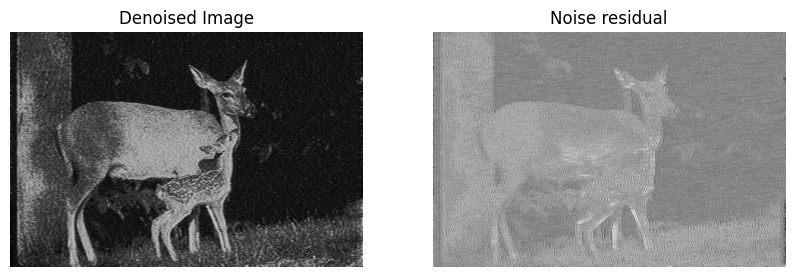

In [12]:
# Display the original and denoised images
im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
image = np.array(im.convert('L'))

image = normalize_image(image)
denoised_image = normalize_image(denoised_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Denoised Image')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Noise residual')
plt.imshow(image-denoised_image, cmap='gray')
plt.axis('off')

plt.savefig('Results/vae_deer.png')
print("done!")

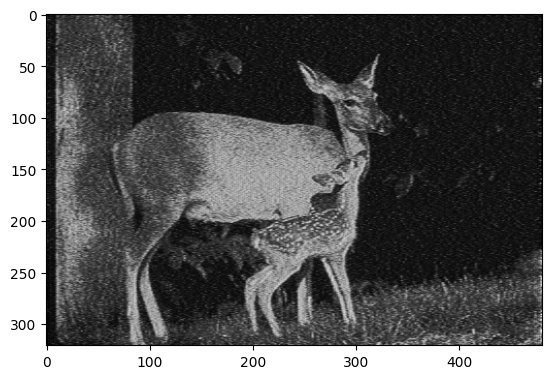

In [13]:
plt.imshow(denoised_image, cmap="gray")

In [14]:
from utils import compute_metrics

im = Image.open("Figures/image2.jpg")
image = np.array(im.convert('L'))
im_gray = normalize_image(image)
denoised_image = normalize_image(denoised_image)

rmse, psnr = compute_metrics(im_gray, denoised_image)

print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.4f}")

RMSE: 22.8692
PSNR: 20.9458
